# P1D Mock Generation - Interactive

This is an initial test for creating P1D mocks, using largely the methods in Naim's 2020 paper, " Optimal 1D Lyα forest power spectrum estimation– I. DESI-lite spectra."

In [1]:
#### imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm

import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate
from scipy.interpolate import interp1d

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

from numpy.polynomial.hermite import hermgauss

In [2]:
plt.rcParams['figure.figsize'] = (8, 4)   
plt.rcParams['font.size'] = 16         
plt.rcParams['axes.titlesize'] = 16     
plt.rcParams['legend.fontsize'] = 14    
plt.rcParams['savefig.dpi'] = 150       
plt.rcParams['axes.labelsize'] = 16   

min_slice = 65000
max_slice = 70000

## Gaussian Random Grid

 (i)  Generate a long, high-resolution Gaussian random grid with equal spacing in velocity v, zero mean, and unit variance.

In [16]:
seed = 10       # for repeatability
size = 2**20
dv = 1.0        # km/s
c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)

# target_redshift = 2.8
# safe_z = '2-8'

target_redshift = 2.8
safe_z = '2-8'

def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    
lambda_min = 3600  # minimum wavelength in Angstroms
lambda_max = 9800  # maximum wavelength in Angstroms

velocity_grid = np.arange(size) - size/2

# Rescale velocity field to match the wavelength range
# Calculate the velocity needed to match the wavelength range
v_min = (lambda_min / lambda_0 - 1) * c
v_max = (lambda_max / lambda_0 - 1) * c

mean (velocity-space):   -0.0010404932425830244
stdev (velocity-space):   1.0005523287554396
shape:  (1048576,)
seed:   10
dv:     1.0


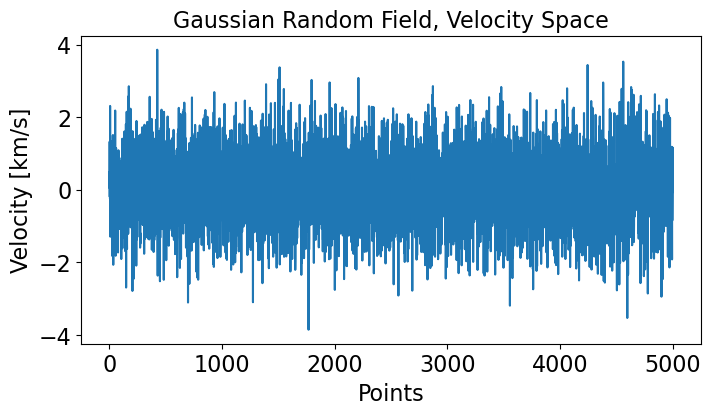

In [17]:
# Generate Gaussian random field in velocity-space
gaussian_random_field = np.random.default_rng(seed).normal(size=size)

# plt.plot(gaussian_random_field)
plt.plot(gaussian_random_field[min_slice:max_slice])
plt.title('Gaussian Random Field, Velocity Space')
plt.xlabel('Points')
plt.ylabel('Velocity [km/s]')

# Check properties
print("mean (velocity-space):  ", gaussian_random_field.mean())
print("stdev (velocity-space):  ", gaussian_random_field.std())
print("shape: ", gaussian_random_field.shape)
print("seed:  ", seed)
print("dv:    ", dv)

## FFT Transformation

 (ii) FFT the grid, and multiply with $\sqrt{P(k) / dv}$ to obtain $ \tilde{\delta}_b(k) $, where dv is the grid spacing in velocity units.

The power spectrum model, $P_G(k)$ comes from the $\xi_G$ best fit.

Inverse FFT and save the variance of this grid, $\sigma^2$. This is a crude Gaussian base for baryon fluctuations, $\delta_b(v)$, with defined power spectrum at $z_0 = 3$.

### FFT on grid

gaussian field k-space shape: (524289,)


Text(0, 0.5, 'Amplitude')

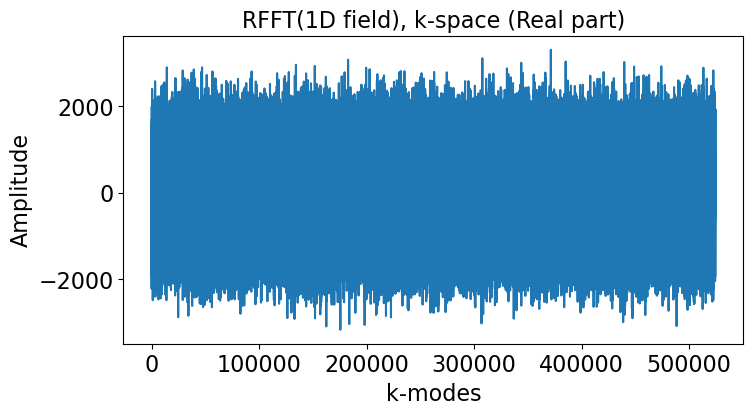

In [18]:
# Compute the FFT to get the field in k-space

gaussian_random_field_k = np.fft.rfft(gaussian_random_field) # normalization ?
print('gaussian field k-space shape: ' + str(gaussian_random_field_k.shape))

plt.plot(np.real(gaussian_random_field_k)) # plot only real part of fft
plt.title('RFFT(1D field), k-space (Real part)')
plt.xlabel('k-modes')
plt.ylabel('Amplitude')

### Make grid of k-modes

In [19]:
# make a grid of k-modes, using same dims as gaussian field
# where d = spacing of the grid

kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi

### Aside: Measuring Power

$$ P(k) = \langle|\tilde{\delta(k)}|^2 \rangle $$

In [211]:
def measure_power(array):
    power = np.abs(array)**2
    return(power)

def measure_scaled_power(array, n, length_scale):
    power = np.abs(array)**2
    scaled_power = power / (n * length_scale)
    return(scaled_power)

Text(0, 0.5, '$ P(k) = \\langle|\\tilde{\\delta(k)}|^2 \\rangle $')

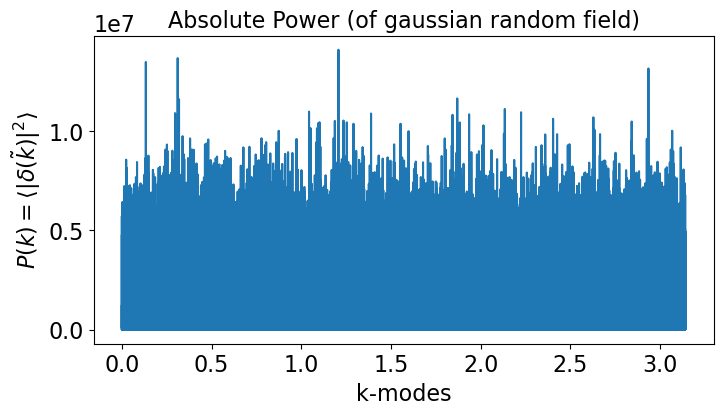

In [212]:
plt.plot(kmodes,measure_power(gaussian_random_field_k))
plt.title('Absolute Power (of gaussian random field)')
plt.xlabel('k-modes')
plt.ylabel(r'$ P(k) = \langle|\tilde{\delta(k)}|^2 \rangle $')

# cannot average across realizations, average across kbins, st each bin has mult. modes (e.g. 8-10 modes)

Text(0, 0.5, 'P(k) / L')

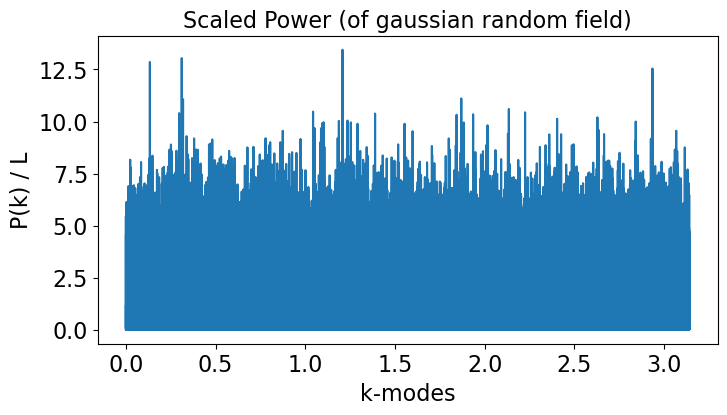

In [213]:
plt.plot(kmodes,measure_scaled_power(gaussian_random_field_k, n = size ,length_scale=1))
plt.title('Scaled Power (of gaussian random field)')
plt.xlabel('k-modes')
plt.ylabel('P(k) / L')


#### Rebinning k-modes

In [214]:
statistic, bin_edges, binnumber = binned_statistic(x = kmodes, values = 
                                                   measure_scaled_power(gaussian_random_field_k, 
                                                    n=size, length_scale=1), 
                                                    statistic = 'mean', bins=40)

In [215]:
print(statistic.shape) # The values of the selected statistic in each bin, mean here
print(bin_edges.shape) # Return the bin edges (length(statistic)+1).
print(binnumber.shape) # Indices of the bins (corresponding to bin_edges) 
                       # in which each value of x belongs. Same length as values 

(40,)
(41,)
(524289,)


Text(0.5, 0, 'k-bins')

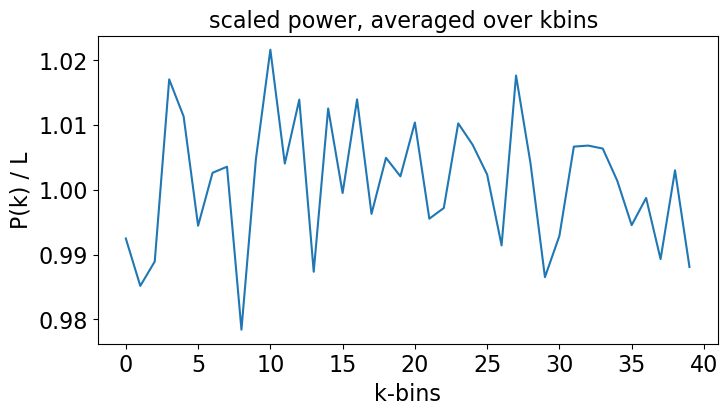

In [216]:
plt.plot(statistic)
plt.title('scaled power, averaged over kbins ')
plt.ylabel('P(k) / L')
plt.xlabel('k-bins')

### Power Spectrum Factor (from file)

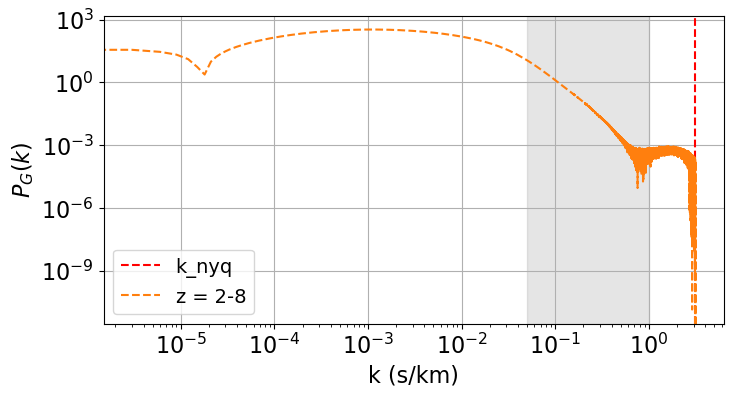

In [20]:
# PG_file_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Backup/P_G-3-0.txt'
PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
data = np.loadtxt(PG_file_path)

# Split into k and P(k)
k_array = data[:, 0]
power_array = data[:, 1]

k_nyquist = np.pi / dv # check Nyquist Frequency
plt.axvline(k_nyquist, color='r', linestyle='--', label='k_nyq')
plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', color='tab:orange',  ls='--')
plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.legend()
plt.grid(True)
plt.show()

$P_G$ is not necessarily the same size as the gaussian random field, so we need to adjust its size before multiplying.

In [21]:
def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    """
    Transforms a Gaussian white noise field in k-space to a correlated
    Gaussian field in velocity-space, using an imported power spectrum.

    Parameters:
    - file_k_array: array of k values from the power spectrum file [s/km]
    - file_power_array: array of P(k) values [arbitrary units]
    - gaussian_random_field_k: white noise field in rfft space
    - dv: spacing of the velocity grid [km/s]

    Returns:
    - delta_b_tilde: scaled k-space field
    - delta_b: real-space Gaussian field
    - P_k: interpolated and used power spectrum
    """
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # size of real-space grid
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k in units of 1/km

    power_interp = interp1d(file_k_array, file_power_array, 
                            kind='linear', bounds_error=False, 
                            fill_value=0.0)
    P_k = power_interp(k)
    
    # Sanitize P_k to ensure it's all finite and non-negative
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)

    # Inverse rFFT to real-space Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N)

    return delta_b_tilde, delta_b, P_k


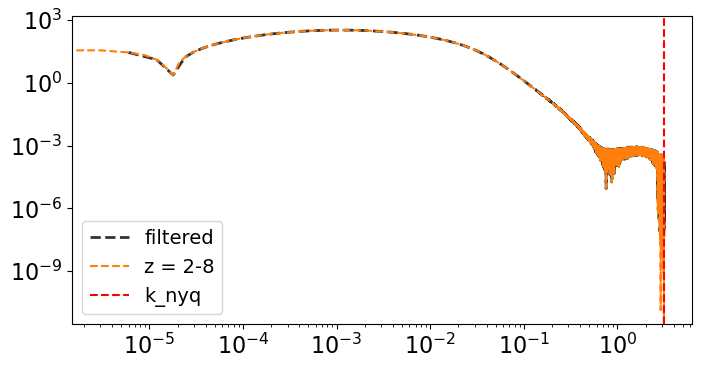

In [22]:
delta_b_tilde, delta_b_v, P_k_damped = delta_transform_1d(k_array, power_array, 
                                         gaussian_random_field_k, dv)

plt.loglog(kmodes[1:], P_k_damped[1:], label='filtered', ls='--', lw=2, color='black', alpha=0.8)
plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', color='tab:orange',  ls='--')
plt.axvline(k_nyquist, color='r', linestyle='--', label='k_nyq')
plt.legend()

Text(0, 0.5, '$\\tilde\\delta_b(k)$')

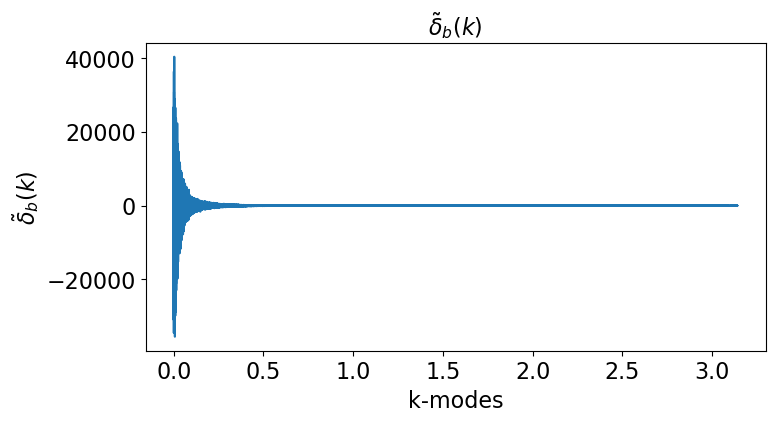

In [23]:
plt.plot(kmodes, np.real(delta_b_tilde))
plt.title(r"$\tilde\delta_b(k)$")
plt.xlabel('k-modes')
plt.ylabel(r"$\tilde\delta_b(k)$")

Variance: 1.452117753924776


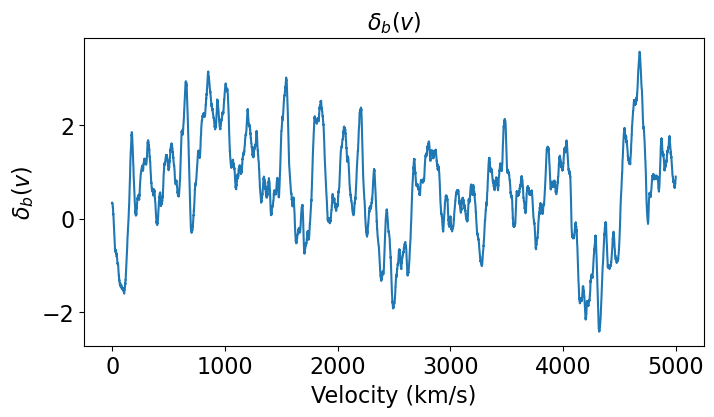

In [24]:
plt.plot(delta_b_v[min_slice:max_slice])
plt.title(r"$\delta_b(v)$")
plt.ylabel(r"$\delta_b(v)$")
plt.xlabel('Velocity (km/s)')

variance_1d = delta_b_v.var() # sigma^2
print(f'Variance: {variance_1d}')

## Redshift Evolution Factor

(iii) Multiply with a redshift evolution factor $a(z)$, such that, 

$\delta_b(z) = a(z)\delta_b(v)$ 

$\sigma^2(z) = a^2(z)\sigma^2(v)$

Redshift evolution: 

$$a^2(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu} $$

where, $z_0 = 3$, and $\nu = 2.16175$, such that: 

$$a(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu / 2} $$


In [25]:
def a2_z(zp, nu=2.16175, z0=3.0):
    return np.power((1. + zp) / (1.+z0), -nu)

def a_z(zp, nu=2.16175, z0=3.0):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))

In [26]:
delta_b_z = delta_b_v * a_z(zp = target_redshift)
redshifted_variance_1d = variance_1d * a2_z(zp = target_redshift)

Text(0.5, 1.0, '$\\delta_b(z)$ (z = 2.8)')

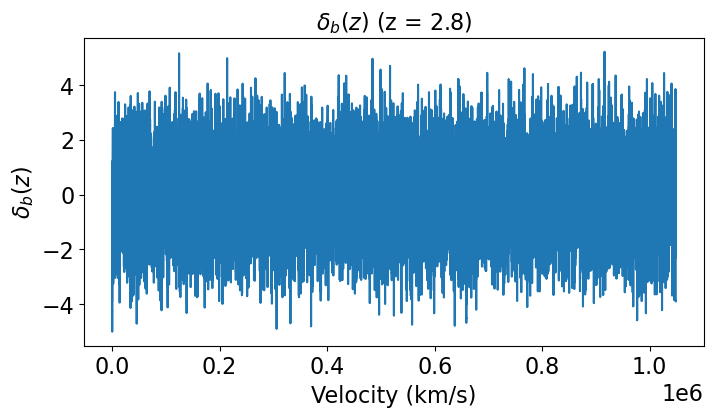

In [27]:
plt.plot(delta_b_z)
plt.ylabel(r'$\delta_b(z)$')
plt.xlabel('Velocity (km/s)')
plt.title(rf'$\delta_b(z)$ (z = {target_redshift})')

## Lognormal Transformation


(iv) Apply a squared lognormal transformtation to approximate the non-linear and non-Gaussian HI column density field:

\begin{align}
n(z) = e^{2\delta_b(z)-\sigma^2(z)}  \tag{22}\\
\end{align}

Text(0.5, 0, 'Velocity (km/s)')

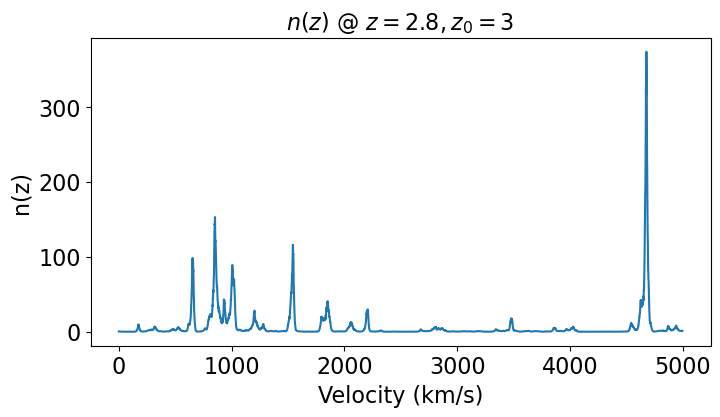

In [28]:
def lognormal_transform(delta_z, sigma2_z):
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)

n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
plt.plot(n_z[min_slice:max_slice])
plt.title(rf'$n(z)$ @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel('n(z)')
plt.xlabel('Velocity (km/s)')

## Optical Depth Transformation

(v) Transform this to optical depth $\tau$ by multiplying with another redshift-dependent function:

Optical Depth: 

$$ \tau(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} $$

where, $z_0 = 3$, $\tau_0 = 673.77e-3$, and $\tau_1 = 5.31008	$

Then, 

$$ x(z) \rightarrow \tau(z) * n(z) $$


$$ x(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} * e^{2 \delta(z) - \sigma^2} $$

In [29]:
def t_of_z(zp, tau0=673.77e-3, tau1=5.31008, z0=3.0):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)

def x_of_z(t_z, n_z):
    return t_z * n_z

def f_of_z(x_z):
    return np.exp(-x_z)

In [30]:
t_z = t_of_z(zp=target_redshift, tau0=673.77e-3, tau1=5.31008, z0=3.0)
x_z = x_of_z(t_z, n_z)

Text(0.5, 0, 'Velocity (km/s)')

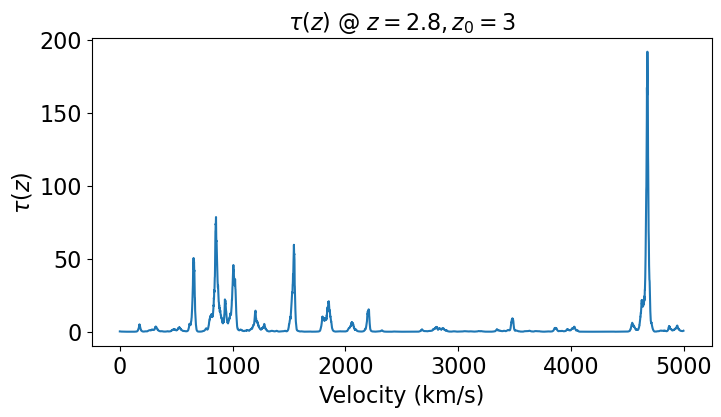

In [31]:
plt.plot(x_z[min_slice:max_slice])
plt.title(rf'$\tau(z)$ @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel(r'$\tau(z)$')
plt.xlabel('Velocity (km/s)')

## Smoothing / Flux

(vi) Finally, the flux is: $ F(z) = e^{-\tau(z)} $

Text(0.5, 0, 'Velocity (km/s)')

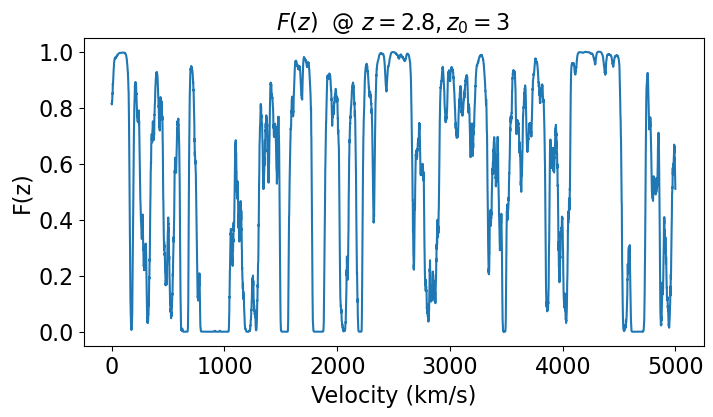

In [32]:
f_z = f_of_z(x_z)

plt.plot(f_z[min_slice:max_slice])
plt.title(rf'$ F(z)$  @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel('F(z)')
plt.xlabel('Velocity (km/s)')

Text(0.5, 0, 'V [km/s]')

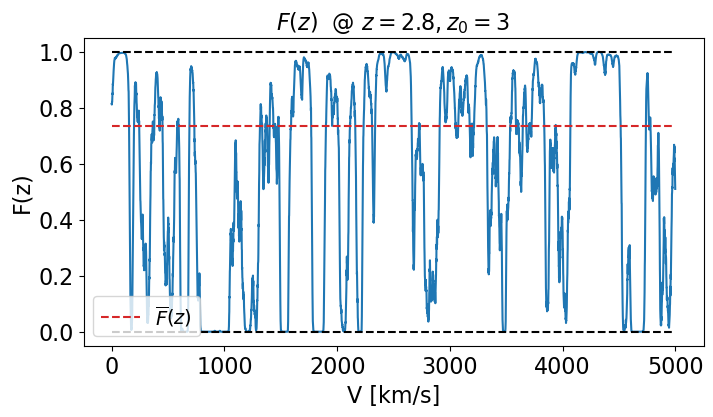

In [33]:
plt.plot(f_z[min_slice:max_slice])
plt.title(rf'$ F(z)$  @ $z = {target_redshift}, z_0 = 3$')
plt.ylabel('F(z)')
plt.hlines(y=0, xmin=0, xmax=5000, color='black', ls='--')
plt.hlines(y=1, xmin=0, xmax=5000, color='black', ls='--')
plt.hlines(y=f_z.mean(), xmin=0,xmax=5000, color='tab:red', ls='--',label=rf'$\overline{{F}}(z)$')
plt.legend(loc = 'lower left')
plt.xlabel('V [km/s]')

#### Transform to wavelength space

$$ v = c \ln(\lambda/\lambda_{pivot}) $$

where, 

$$ \lambda_{pivot} = (1+z_{pivot}) \lambda_{Ly\alpha} $$

and $\lambda_{Ly\alpha} = 1215.67 \dot{A} $. 

So, need to plot flux against the wavelngth grid, given by, 

$$ \lambda = \lambda_{pivot} \exp[(v - v_0) /c] $$

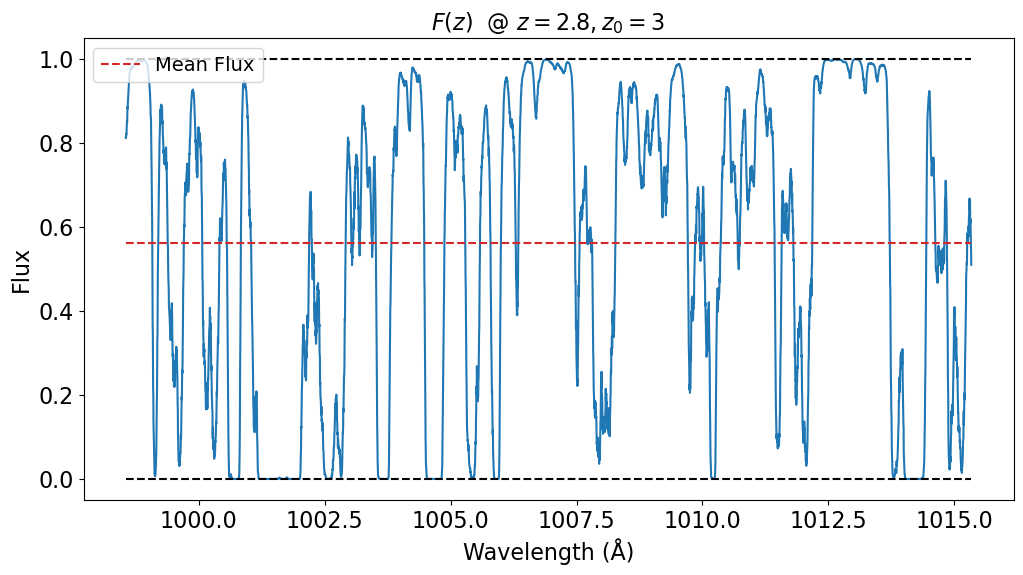

In [34]:
# Generate the wavelength grid
wavelength_field = lambda_c(z=target_redshift)* (np.exp(velocity_grid / c))

# Calculate optical depth for given redshift
tau_z = t_z

# Calculate flux
flux_z = f_z

# Plot the flux vs wavelength
plt.figure(figsize=(12, 6))
plt.plot(wavelength_field[min_slice:max_slice], flux_z[min_slice:max_slice])  # Use wavelength_field for x-axis and flux_z for y-axis
plt.title(rf'$ F(z)$  @ $z = {target_redshift}, z_0 = 3$')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.hlines(y=flux_z[min_slice:max_slice].mean(), xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='tab:red', ls='--', label='Mean Flux')
plt.hlines(y=0, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
plt.hlines(y=1, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
plt.legend(loc = 'upper left')
plt.show()

Interractive flux transmission field using Widgets

In [35]:

def plot_flux(z):
    # Generate the wavelength grid
    wavelength_field = lambda_c(z) * (np.exp(velocity_grid / c))

    # Calculate optical depth for given redshift
    delta_z = delta_b_v * a_z(z)
    redshifted_variance = variance_1d * a2_z(z)
    t_z = t_of_z(z)
    n_z = lognormal_transform(delta_z, redshifted_variance)
    x_z = x_of_z(t_z, n_z)
    flux_z = f_of_z(x_z)
    mean_flux = flux_z.mean()

    # Plot the flux vs wavelength
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_field[min_slice:max_slice], flux_z[min_slice:max_slice], label='z = '+ str(z))  
    plt.title(r'$ F(z) = e^{-\tau(z)}$')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.hlines(y=mean_flux, xmin=wavelength_field[min_slice:max_slice].min(), 
               xmax=wavelength_field[min_slice:max_slice].max(), color='red', ls='--', 
               label=rf'$\overline{{F}}$ = {mean_flux:.2f}')
    plt.hlines(y=0, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
    plt.hlines(y=1, xmin=wavelength_field[min_slice:max_slice].min(), xmax=wavelength_field[min_slice:max_slice].max(), color='black', ls='--')
    plt.legend(loc='lower left')
    plt.show()


interact(plot_flux, z = widgets.FloatSlider(value=target_redshift,
                                                      min=1.0,
                                                      max=5.0,
                                                      step=0.1))


interactive(children=(FloatSlider(value=2.8, description='z', max=5.0, min=1.0), Output()), _dom_classes=('wid…

<function __main__.plot_flux(z)>

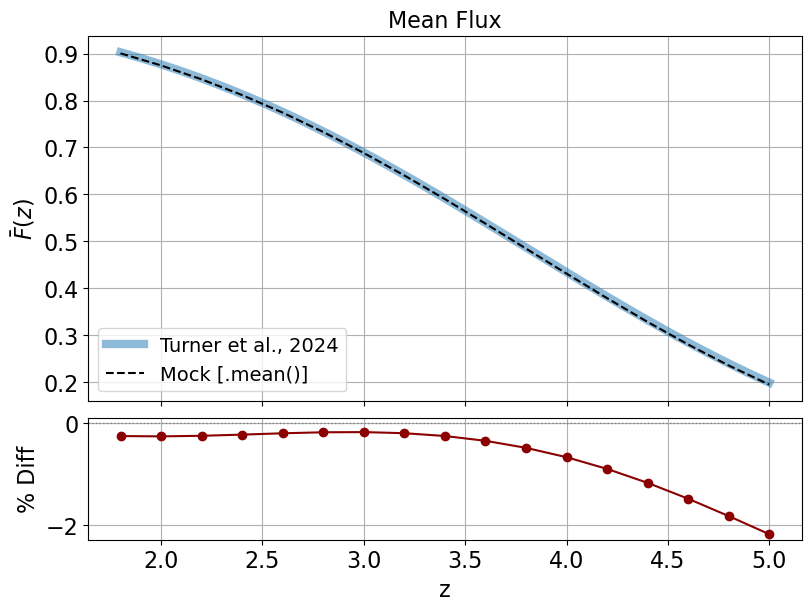

In [36]:
def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)

z_array = np.linspace(1.8, 5.0, 500)
measured_mean_flux = []

zlist = np.array([1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0])

for z in zlist:
    delta_z = delta_b_v * a_z(z)
    redshifted_variance = variance_1d * a2_z(z)
    t_z = t_of_z(z)
    n_z = lognormal_transform(delta_z, redshifted_variance)
    x_z = x_of_z(t_z, n_z)
    flux_z = f_of_z(x_z)
    mean_flux = flux_z.mean()
    measured_mean_flux.append(mean_flux)

# Model and percent difference
model_flux_at_measured_z = turner24_mf(zlist)
residuals = 100 * (np.array(measured_mean_flux) - model_flux_at_measured_z) / model_flux_at_measured_z

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]}, constrained_layout=True)

# Mean flux
ax1.plot(z_array, turner24_mf(z_array), label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(zlist, measured_mean_flux, label='Mock [.mean()]', ls='--', color='black')
ax1.set_ylabel(r'$\bar F(z)$')
ax1.set_title('Mean Flux')
ax1.legend(loc='lower left')
ax1.grid()

# Percent difference
ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(zlist, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()

plt.show()


### Mean Flux

Them mean flux and power spectrum of these mocks can be analytically computed. Using one-point probability of the base Gaussian random field, $\delta$, we can write down the following integral for the mean flux: 

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv \tau_0 (\frac{1+z}{1+z_0})^{\tau_1} e^{-a^2(z)\sigma^2} $$

In [401]:
# the following are used for the GHQ mean flux calculation

def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)

def x_z(z, sigma2, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)

def mean_flux(z, variance, z0=3):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)

In [402]:
print(f'Turner 24: {turner24_mf(target_redshift)}')
print(f'np.mean  : {f_z.mean()}')
print(f'GHQ mean : {mean_flux(z=target_redshift, variance=variance_1d, z0=3)}')

Turner 24: 0.3823884497673086
np.mean  : 0.3472794612734031
GHQ mean : 0.34647704706440774


/tmp/ipykernel_2001569/602472471.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))


#### Mean Flux vs Redshift

In [403]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5.0])

In [404]:
flux_list = []
for i in z_list:
    flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))

/tmp/ipykernel_2001569/602472471.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))


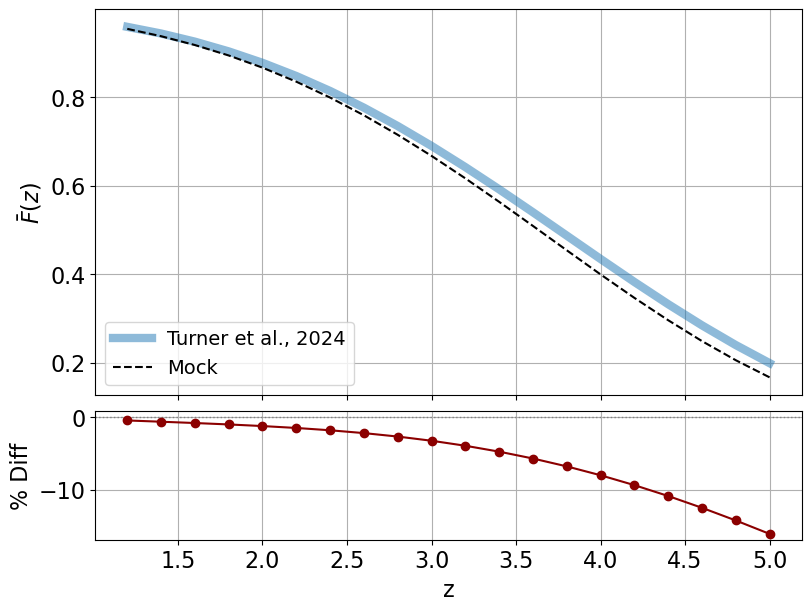

In [405]:
# Turner et al. (2024) model
turner_flux = np.exp(-2.46e-3 * (1 + z_list)**3.62)

# Calculate percent difference
residuals = 100 * (flux_list - turner_flux) / turner_flux

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), 
                               gridspec_kw={'height_ratios': [3, 1]}, 
                               constrained_layout=True)

# Top panel: mean flux comparison
ax1.plot(z_list, turner_flux, label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(z_list, flux_list, label='Mock', ls='--', color='black')
ax1.set_ylabel(r'$\bar F(z)$')
# ax1.set_title('Mean Flux Comparison')
ax1.legend(loc='lower left')
ax1.grid()

# Bottom panel: percent difference
ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(z_list, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()

plt.show()


### Measure Power

The next test would be to measure the power spectrum, using the ratio of flux / mean flux (analytical), and comparing to the power of the gaussian random field. 

Define flux power spectrum (FPS) as: 

$$ \delta_F \equiv \frac{F - \langle F \rangle}{\langle F \rangle} $$

Where $\langle F \rangle$ is the average flux ($\overline F$)

$$ P_F(k) = \delta_f(k) * \delta_f(k) $$
where $\delta_F(k)$ is the Fourier transform of the flux overdensity.

In [406]:
def delta_F(z, variance, input_flux, z0=3):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)

def delta_F_k(z, variance, input_flux, z0=3):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    delta_f_tilde = np.fft.rfft(delta_f)
    return(delta_f_tilde)

def P_F(delta_f):
    delta_f_tilde = np.fft.rfft(delta_f)
    P_F = np.abs(delta_f_tilde)**2 / (delta_f.size * dv)
    return(P_F)

In [407]:

# test_flux = flux_z
test_flux = f_z
delta_f = delta_F(z=target_redshift, variance=redshifted_variance_1d, input_flux=test_flux, z0=3)
test_power = P_F(delta_f)

N = len(delta_f)

# kmodes2 = (np.fft.rfftfreq(n=2*(test_power.size), d=dv) * 2 * np.pi) + 1e-12 
kmodes2 = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi

window = (kmodes2 > 1e-5) & (kmodes2 < 0.05)  # Window for k_arr


/tmp/ipykernel_2001569/602472471.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))


In [408]:
print(f'Shape gaussian field v: {gaussian_random_field.shape}')
print(f'Shape gaussian field k: {gaussian_random_field_k.shape}')
print(f'Shape kmodes: {kmodes.shape}')
print(f'Shape delta_b_tilde: {delta_b_tilde.shape}')
print(f'Shape delta_b_v: {delta_b_v.shape}')
print(f'Shape P_k_filtered: {P_k_damped.shape}')
print(f'Shape delta_b_z: {delta_b_z.shape}')
print(f'Shape n_z: {n_z.shape}')
print(f'Shape x_z: {x_z.shape}')
print(f'Shape f_z: {f_z.shape}')
print(f'Shape delta_f: {delta_f.shape}')
print(f'Shape measured_power: {test_power.shape}')

Shape gaussian field v: (1048576,)
Shape gaussian field k: (524289,)
Shape kmodes: (524289,)
Shape delta_b_tilde: (524289,)
Shape delta_b_v: (1048576,)
Shape P_k_filtered: (524289,)
Shape delta_b_z: (1048576,)
Shape n_z: (1048576,)


AttributeError: 'function' object has no attribute 'shape'

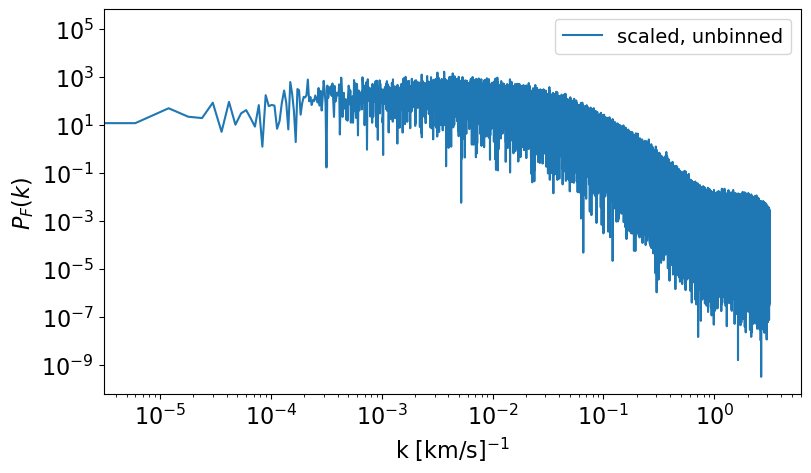

In [409]:
plt.loglog(kmodes2, test_power, label='scaled, unbinned')
plt.ylabel(r'$P_F(k)$ ')
plt.xlabel('k [km/s$]^{-1}$')
plt.legend()

statistic shape:  500
bin edges shape:  501
bin number shape: 8343


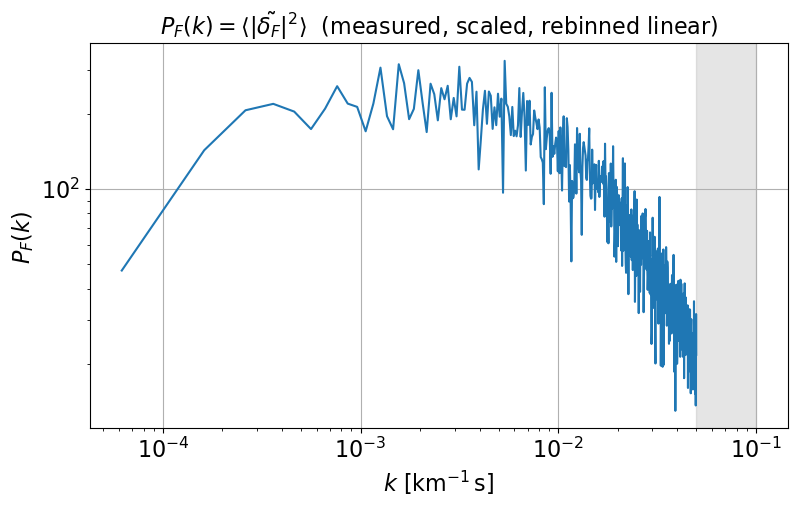

In [410]:
window = (kmodes2 > 1e-5) & (kmodes2 < 0.05)  # Window for k_arr

statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[window], 
                                                                  values = test_power[window], 
                                                                  statistic = 'mean', bins=500)
print("statistic shape:  " + str(statistic_test.shape[0])) # The values of the selected statistic in each bin, mean here
print("bin edges shape:  " + str(bin_edges_test.shape[0])) # Return the bin edges (length(statistic)+1).
print("bin number shape: " + str(binnumber_test.shape[0])) # Indices of the bins (corresponding to bin_edges) 
                                                           # in which each value of x belongs. Same length as values 
    
    
bin_centers = 0.5 * (bin_edges_test[1:] + bin_edges_test[:-1])
plt.loglog(bin_centers, statistic_test)

# plt.loglog(bin_edges_test[4:], statistic_test[3:])
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$  (measured, scaled, rebinned linear)')
plt.ylabel(r'$P_F(k)$ ')
plt.xlabel(r'$k\ \left[\mathrm{km}^{-1}\,\mathrm{s}\right]$')
plt.rcParams["figure.figsize"] = (9,5)
plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.grid(True)

In [411]:
def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    window = (kmodes > 1e-5) & (kmodes < 0.05)  # Window for k_arr
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[window],
                                                       values=power[window],
                                                       statistic='mean', bins=500)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    k_arr = bin_centers
    
    # Remove invalid points
    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    # Initial guess
    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    # Now safe to call curve_fit
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)

    print(f'measured_power size: {power.size}')
    print(f'delta_f size: {delta_f.size}')


    return bin_centers, statistic, *popt_mock

measured_power size: 524289
delta_f size: 1048576


/tmp/ipykernel_2001569/602472471.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (a_z(z)) * x)))
/tmp/ipykernel_2001569/563066587.py:7: RuntimeWarning: overflow encountered in power
  result = (A * np.pi / PD13_PIVOT_K) * np.power(
/tmp/ipykernel_2001569/563066587.py:11: RuntimeWarning: invalid value encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)


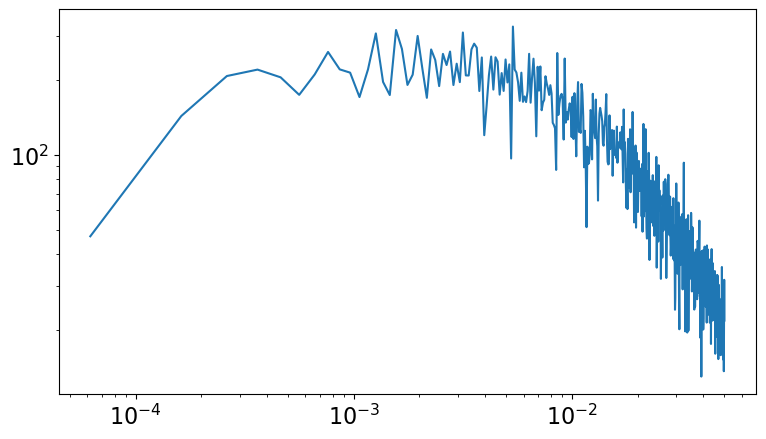

In [413]:
test_flux = flux_z
delta_f = delta_F(z=target_redshift, variance=redshifted_variance_1d, input_flux=test_flux, z0=3)
test_power = P_F(delta_f)
bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, z_target)


plt.loglog(bin_centers, stat)


Add DESI measurement / model

In [414]:
DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)
PD13_PIVOT_K = 0.009  # note: k_0
PD13_PIVOT_Z = 3.0    # note: z0 = 3

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result

DESI_model = evaluatePD13Lorentz((bin_centers, z), *DESI_EDR_PARAMETERS)


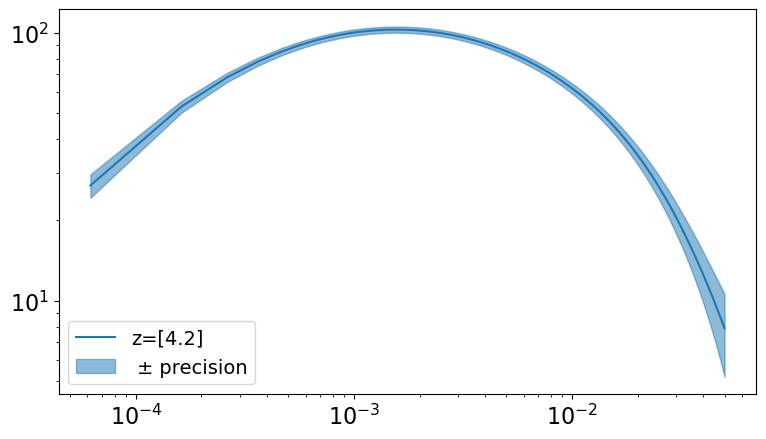

In [415]:
# DESI_model = evaluatePD13Lorentz((bin_centers, 3.0), *DESI_EDR_PARAMETERS)

z_target = np.array([4.2])

p1d_edr_fit = np.empty((z_target.size, bin_centers.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
for i, z in enumerate(z_target):
    p1d_edr_fit[i] = evaluatePD13Lorentz((bin_centers, z), *DESI_EDR_PARAMETERS)

p1d_precision = 1e-1
w_k = (bin_centers > 1e-5) & (bin_centers < 0.05)  # Window for k_arr
ptrue = p1d_edr_fit[:, w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

idx = np.where(z_target == z)[0]
redshift_index = idx[0]

# Extract data using index mask (w_k)
temp_k = bin_centers[w_k]
temp_p = p1d_edr_fit[redshift_index, w_k]
temp_e = np.full_like(temp_k, e_p1d[redshift_index])

plt.loglog(bin_centers[w_k], p1d_edr_fit[redshift_index, w_k], 
           color='tab:blue', label=f'z={z_target}')

alpha_shade = 0.3
# Plot shaded error band instead of individual error bars
plt.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e,
                 color='tab:blue', alpha=0.5, label=' ± precision')
plt.legend()

In [416]:
# desi_model = evaluatePD13Lorentz((bin_centers, 3.2), *DESI_EDR_PARAMETERS)
# w_k = (bin_centers > 1e-5) & (bin_centers < 0.05)  # Window for k_arr
# ep1d = 0.1 * desi_model

# plt.fill_between(bin_centers[w_k], desi_model[w_k] - ep1d[w_k], 
#         desi_model[w_k] + ep1d[w_k],
#         color='tab:blue', alpha=alpha_shade,label=' ± precision')

# plt.loglog(bin_centers, desi_model)

In [417]:
# desi_model = evaluatePD13Lorentz((bin_centers, 3.2), *DESI_EDR_PARAMETERS)

# p1d_precision = 1e-1
# w_k = (bin_centers > 1e-5) & (bin_centers < 0.05)  # Window for k_arr
# ptrue = desi_model[w_k].ravel()
# e_p1d = p1d_precision * ptrue + 1e-8

# # Extract data using index mask (w_k)
# temp_k = bin_centers[w_k]
# temp_p = desi_model[w_k]
# temp_e = np.full_like(temp_k, e_p1d)

# plt.loglog(bin_centers[w_k], desi_model[w_k], 
#            color='tab:blue', label=f'z={3.2}')

# alpha_shade = 0.3
# # Plot shaded error band instead of individual error bars
# plt.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e,
#                  color='tab:blue', alpha=0.5, label=' ± precision')
# plt.legend()

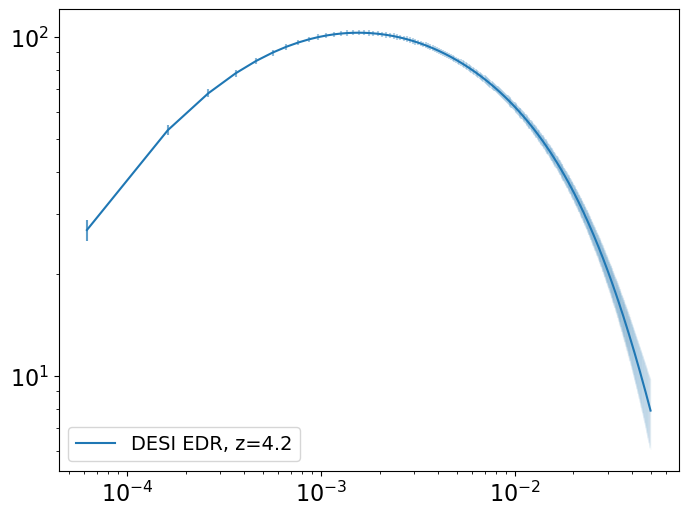

In [421]:
k_arr  = bin_centers 
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6,4.8,5.0])

DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)

# set pivot points for k and z using fiducial power estimate
PD13_PIVOT_K = 0.009 # note: k_0
PD13_PIVOT_Z = 3.0   # note: z0 = 3

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result

# fit P1D of DESI EDR
# Start with an empty array the size / shape of k and z arrays
p1d_edr_fit = np.empty((zlist.size, k_arr.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
for i, z in enumerate(zlist):
    p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)

p1d_precision = 1e-1
w_k = (k_arr > 1e-5) & (k_arr < 0.05)  # Window for k_arr
ptrue = p1d_edr_fit[:, w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

redshift_index = 11 # (z = 4.0)

# Extract data using index mask (w_k)
temp_k = k_arr[w_k]
temp_p = p1d_edr_fit[redshift_index, w_k]
temp_e = np.full_like(temp_k, e_p1d[redshift_index])

# Normalize k_values on a log scale, then map alpha to a smooth range
log_k_values = np.log10(temp_k)  # Take log of k-values
log_k_min = np.min(log_k_values)
log_k_max = np.max(log_k_values)

# Set alpha values to decrease logarithmically: higher alpha for lower k (log(k)) values
alpha_values = 0.02 + (1 - 0.3) * (log_k_max - log_k_values) / (log_k_max - log_k_min)

plt.figure(figsize=(8,6))

# Loop over each point to plot errorbars with its specific alpha
for k_val, p_val, err, alpha_val in zip(temp_k, temp_p, temp_e, alpha_values):
    plt.errorbar(k_val, p_val, yerr=err, color='tab:blue', alpha=alpha_val)

plt.loglog(k_arr[w_k], p1d_edr_fit[redshift_index, w_k], 
           color='tab:blue', label=rf'DESI EDR, z={zlist[redshift_index]}')

plt.legend()

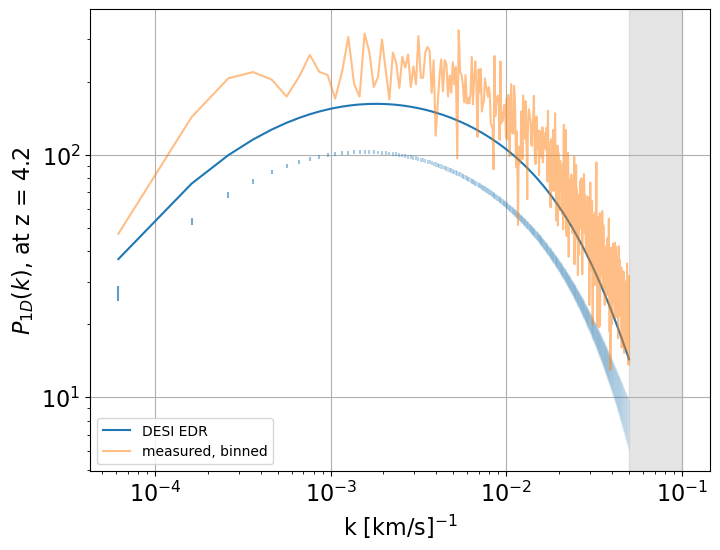

In [422]:
plt.figure(figsize=(8,6))

# Loop over each point to plot errorbars with its specific alpha
for k_val, p_val, err, alpha_val in zip(temp_k, temp_p, temp_e, alpha_values):
    plt.errorbar(k_val, p_val, yerr=err, color='tab:blue', alpha=alpha_val)

plt.loglog(k_arr[w_k], p1d_edr_fit[15, w_k], 
           color='tab:blue', label=r'DESI EDR')

plt.loglog(bin_centers[w_k], statistic_test[w_k], alpha=0.5,
           color='tab:orange', ls='-', label='measured, binned')


# plt.loglog(kmodes2, test_power_scaled, alpha=0.4, 
#            label = 'Measured, unbinned', color='tab:green')


plt.grid(True)
plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.ylabel(r'$P_{1D}(k)$, at z = ' + str(zlist[redshift_index]))
plt.xlabel('k [km/s$]^{-1}$')
plt.legend(fontsize=10, loc='lower left')

plt.show()

In [79]:
# # diagnostic plot

# plt.figure(figsize=(8,6))
# plt.plot(bin_centers, statistic_test, alpha=0.5,
#          label="Mock (binned)", color='tab:orange')
# plt.plot(bin_centers, p1d_edr_fit[redshift_index],
#          label="DESI EDR (model)", color='tab:blue')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel(r'$k$ [km$^{-1}$ s]')
# plt.ylabel(r'$P_{1D}(k)$')
# plt.legend()
# plt.grid(True, which='both', ls='--')
# plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
# plt.title("Direct overlay: no windowing or errorbars")
# plt.tight_layout()
# plt.show()

#### try to get a trendline + residual

In [180]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Model: power spectrum in log-log space
def loglog_poly(k, a0, a1, a2):
    logk = np.log10(k)
    return a0 + a1 * logk + a2 * logk**2

# Clean input
valid = (statistic_test > 0) & np.isfinite(statistic_test)
k_vals = bin_centers[valid]
P_mock_vals = statistic_test[valid]
P_desi_vals = p1d_edr_fit[redshift_index, valid]
sigma_desi = p1d_precision * P_desi_vals + 1e-8

# Fit mock
popt_mock, pcov_mock = curve_fit(loglog_poly, k_vals, np.log10(P_mock_vals))
P_mock_fit = 10**loglog_poly(k_vals, *popt_mock)

# Fit DESI
popt_desi, pcov_desi = curve_fit(loglog_poly, k_vals, np.log10(P_desi_vals))
P_desi_fit = 10**loglog_poly(k_vals, *popt_desi)

# Parameter uncertainties
perr_mock = np.sqrt(np.diag(pcov_mock))
perr_desi = np.sqrt(np.diag(pcov_desi))


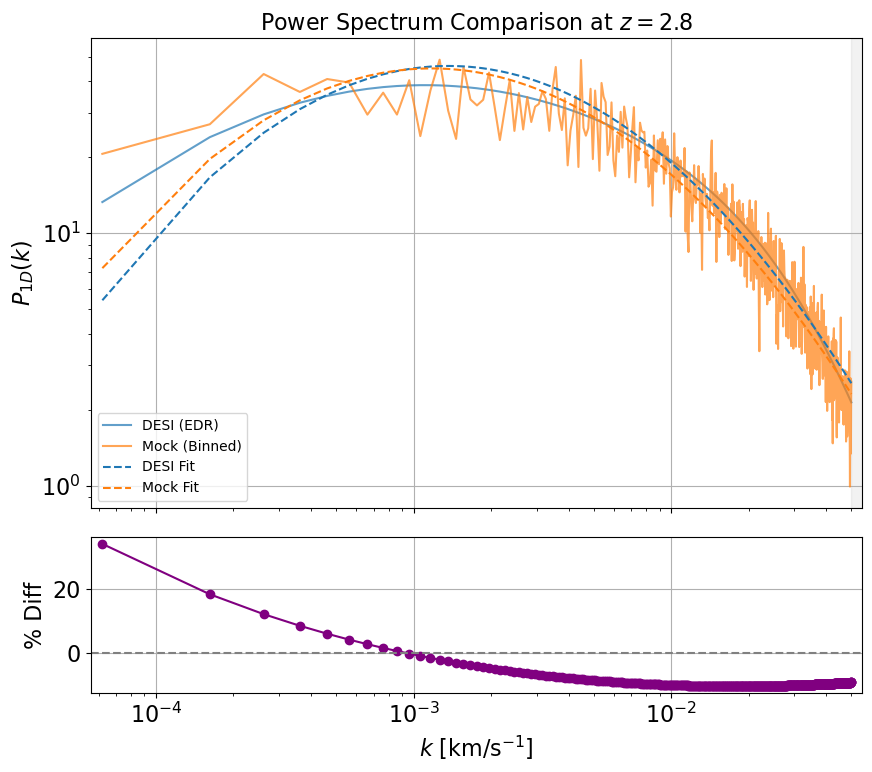

In [186]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# --- TOP PLOT: Power Spectra + Trendlines ---
ax1.loglog(k_vals, P_desi_vals, label='DESI (EDR)', color='tab:blue', alpha=0.7)
ax1.loglog(k_vals, P_mock_vals, label='Mock (Binned)', color='tab:orange', alpha=0.7)

ax1.loglog(k_vals, P_desi_fit, '--', label='DESI Fit', color='tab:blue')
ax1.loglog(k_vals, P_mock_fit, '--', label='Mock Fit', color='tab:orange')

ax1.axvspan(0.05, 0.1, alpha=0.1, color='gray')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(fontsize=10, loc='lower left')
ax1.grid(True)
ax1.set_title(r'Power Spectrum Comparison at $z = {:.1f}$'.format(zlist[redshift_index]))

# --- BOTTOM PLOT: Percent Difference ---
residual_percent = 100 * (P_mock_fit - P_desi_fit) / P_desi_fit
ax2.plot(k_vals, residual_percent, 'o-', color='purple')
ax2.axhline(0, linestyle='--', color='gray')
ax2.set_ylabel('% Diff')
ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.grid(True)

# Format shared x-axis
ax2.set_xscale('log')
ax1.set_xlim([np.min(k_vals)*0.9, np.max(k_vals)*1.1])

plt.tight_layout()
plt.show()


In [189]:
chi2 = np.sum(((P_mock_fit - P_desi_fit) / sigma_desi) ** 2)
ndof = len(k_vals) - len(popt_desi)  # Number of degrees of freedom
reduced_chi2 = chi2 / ndof

print_fit("Mock", popt_mock, perr_mock)
print_fit("DESI", popt_desi, perr_desi)
print(f"Chi-squared: {chi2:.2f}")
print(f"Reduced Chi-squared: {reduced_chi2:.2f}")

Mock fit parameters:
  a0 = -2.5170 ± 0.0691
  a1 = -2.8449 ± 0.0676
  a2 = -0.4853 ± 0.0156

DESI fit parameters:
  a0 = -2.5567 ± 0.0270
  a1 = -2.9457 ± 0.0264
  a2 = -0.5142 ± 0.0061

Chi-squared: 472.24
Reduced Chi-squared: 0.95


#### try PD13 model for trendline

In [369]:
# PD13_PIVOT_K = 0.009
# PD13_PIVOT_Z = 3.0

# def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
#     k, z = X
#     q0 = k / PD13_PIVOT_K + 1e-10
#     result = (A * np.pi / PD13_PIVOT_K) * np.power(
#         q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
#     if z is not None:
#         x0 = (1. + z) / (1. + PD13_PIVOT_Z)
#         result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
#     return result


In [370]:
# fit to binned mock data

from scipy.optimize import curve_fit

# Initial guess: could start near DESI parameters or tweak slightly
p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)

# Fit the mock data
popt_mock, pcov_mock = curve_fit(
    lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz((k,z_target), 
                                            A, n, alpha, B, beta, lmd),
    bin_centers, statistic_test, p0=p0, maxfev=20000)

mock_fit = evaluatePD13Lorentz((bin_centers,z_target), *popt_mock)
perr_mock = np.sqrt(np.diag(pcov_mock))
mock_upper = evaluatePD13Lorentz((bin_centers,z_target), *(popt_mock + perr_mock))
mock_lower = evaluatePD13Lorentz((bin_centers,z_target), *(popt_mock - perr_mock))

desi_model = evaluatePD13Lorentz((bin_centers,z_target), *DESI_EDR_PARAMETERS)
percent_diff = 100 * (mock_fit - desi_model) / desi_model

/tmp/ipykernel_2001569/563066587.py:11: RuntimeWarning: overflow encountered in power
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_2001569/563066587.py:11: RuntimeWarning: overflow encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_2001569/563066587.py:11: RuntimeWarning: invalid value encountered in multiply
  result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
/tmp/ipykernel_2001569/563066587.py:7: RuntimeWarning: overflow encountered in power
  result = (A * np.pi / PD13_PIVOT_K) * np.power(


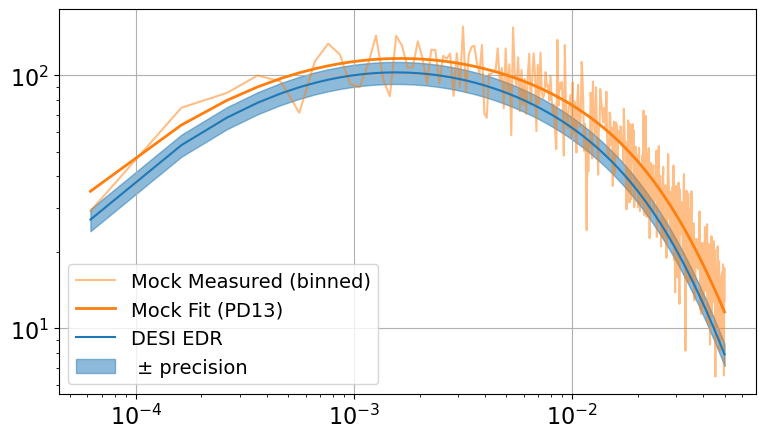

In [375]:
# fit P1D of DESI EDR
# Start with an empty array the size / shape of k and z arrays
# p1d_edr_fit_2 = np.empty((zlist.size, bin_centers.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
# for i, z in enumerate(z_target):

z_target = 4.2
p1d_edr_fit_2 = evaluatePD13Lorentz((bin_centers, z_target), *DESI_EDR_PARAMETERS)

p1d_precision = 1e-1
w_k = (bin_centers > 1e-5) & (bin_centers < 0.05)  # Window for k_arr
ptrue = p1d_edr_fit_2[w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

# Extract data using index mask (w_k)
temp_k = bin_centers[w_k]
temp_p = p1d_edr_fit_2[w_k]
temp_e = np.full_like(temp_k, e_p1d)

# Normalize k_values on a log scale, then map alpha to a smooth range
log_k_values = np.log10(temp_k)  # Take log of k-values
log_k_min = np.min(log_k_values)
log_k_max = np.max(log_k_values)

plt.loglog(bin_centers, statistic_test, color='tab:orange', label='Mock Measured (binned)', alpha=0.5)
plt.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)
plt.loglog(bin_centers[w_k], p1d_edr_fit_2[w_k], 
           color='tab:blue', label=r'DESI EDR')

plt.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e,
                 color='tab:blue', alpha=0.5, label=' ± precision')
plt.legend()

plt.grid(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


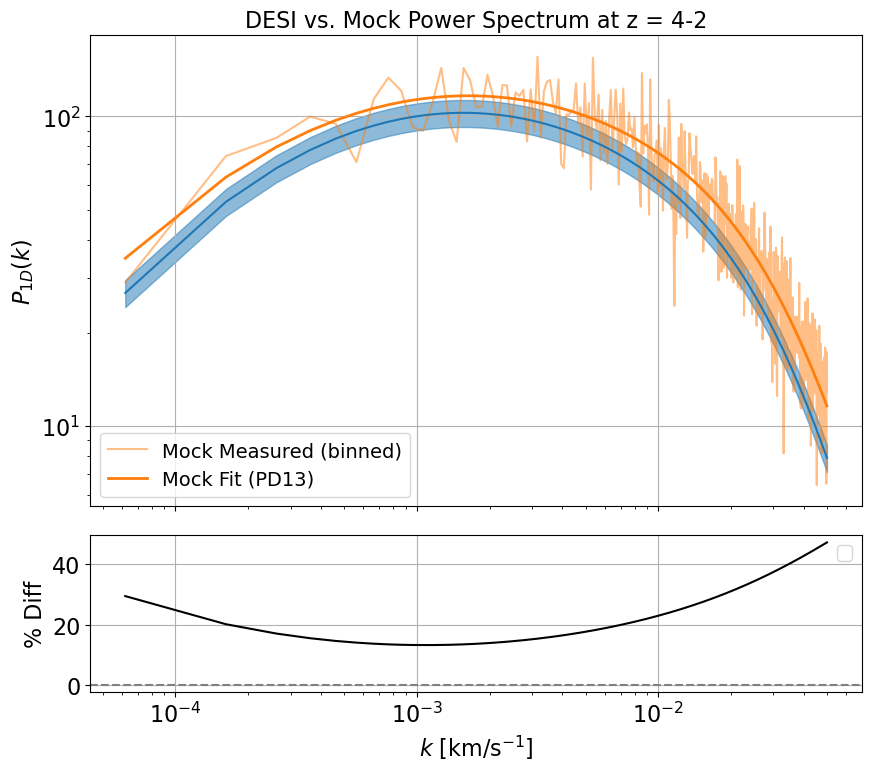

In [372]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Upper plot
ax1.loglog(bin_centers, statistic_test, color='tab:orange', label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)

ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')

# Lower plot (residuals)
ax2.semilogx(bin_centers, percent_diff, color='black')
ax2.axhline(0, ls='--', color='gray')
ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('% Diff')
ax2.grid(True)

ax1.loglog(k_arr[w_k], p1d_edr_fit_2[w_k], 
    color='tab:blue', label=r'DESI EDR')

ax1.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e,
                 color='tab:blue', alpha=0.5, label=' ± precision')
plt.legend()

plt.tight_layout()
plt.show()


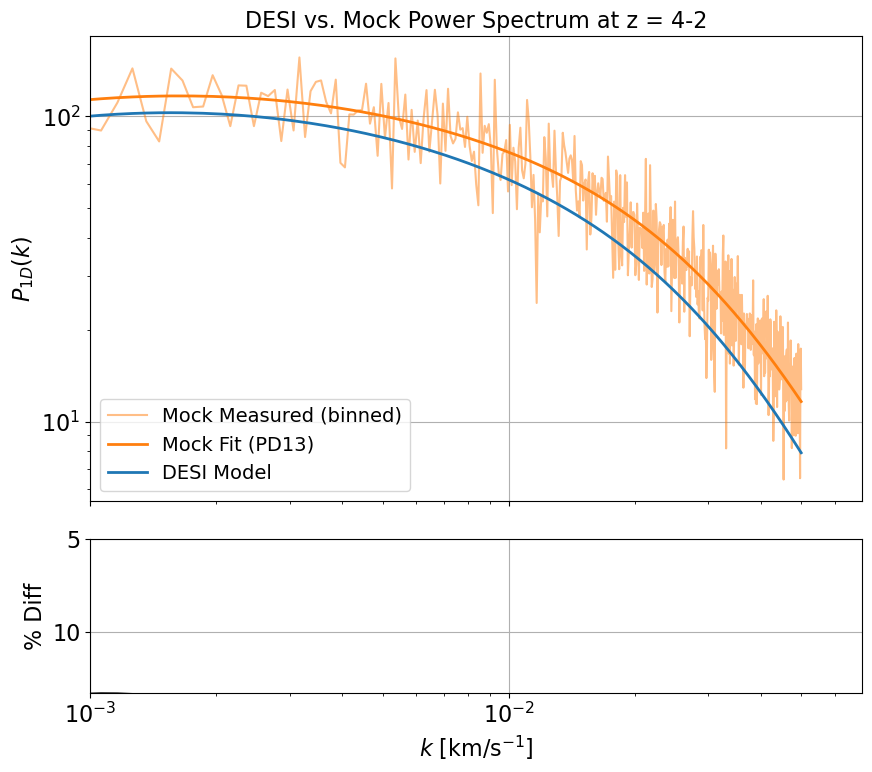

In [374]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Upper plot
ax1.loglog(bin_centers, statistic_test, color='tab:orange', label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)
# ax1.fill_between(bin_centers, mock_lower, mock_upper, color='tab:orange', alpha=0.3, label='1σ Band')

ax1.loglog(bin_centers, desi_model, color='tab:blue', label='DESI Model', lw=2)
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_xlim(left=1e-3)
# ax1.axvspan(0.05, 0.1, alpha=0.2, color='grey')
ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')

# Lower plot (residuals)
ax2.semilogx(bin_centers, percent_diff, color='black')
ax2.axhline(0, ls='--', color='gray')
# ax2.axvspan(0.05, 0.1, alpha=0.2, color='grey')
ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('% Diff')
ax2.set_ylim(percent_diff.min(), 5)
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def plot_power_array(ax, z, variance, k_field, kmodes, color, dv=1, z0=3): 
    delta_b_v = delta_transform(k_field, kmodes, dv)
    variance_1d = delta_b_v.var()  # sigma^2
    
    delta_b_z = delta_b_v * redshift_evolution(z, z0)
    redshifted_variance = variance_1d * redshift_evolution(z, z0)**2
    
    test_flux = flux(optical_depth_transform(lognormal_transform(delta_b_z, redshifted_variance)))

    delta_f = delta_F(z=z, variance=variance_1d, input_flux=test_flux, z0=z0)
    test_power = P_F(delta_f)
    test_power2 = measure_scaled_power(delta_F_k(z=z0, input_flux=test_flux, variance=variance_1d, z0=z0), n=test_power.size, length_scale=1)
    kmodes2 = (np.fft.rfftfreq(n=2*(test_power.size), d=1) * 2 * np.pi) + 1e-12 

    statistic_test, bin_edges_test, binnumber_test = binned_statistic(
        x=kmodes2[10:25000], values=test_power2[10:25000], 
        statistic='mean', bins=1000)
    
    ax.loglog(bin_edges_test[4:], (bin_edges_test[4:] / np.pi) * statistic_test[3:], 
              label=f'z = {z}', color=color, alpha=1)
    
    ax.axvspan(0.025, 0.13, alpha=0.3, color='grey')  # Vertical shaded region
    ax.set_title(f'z = {z}')
    ax.set_ylabel(r'k  $P_F(k)$ / $\pi$')
    ax.set_xlabel('k [km/s$]^{-1}$')
    ax.grid(True)
    ax.set_ylim(10e-5, 10e-2)

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])
norm = plt.Normalize(min(zlist), max(zlist))  # Normalize to the range of z_list

# Create subplots with multiple rows and columns (e.g., 4 rows, 4 columns)
nrows = 4
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axs = axs.flatten()  # Flatten the grid of subplots for easy iteration


for i, z in enumerate(zlist):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plot_power_array(ax=axs[i], z=z, variance=variance_1d, k_field=gaussian_random_field_k, kmodes=kmodes, dv=1, z0=3, color='black')
    # plot_power_array(ax=axs[i], z=z, variance=variance_1d, k_field=gaussian_random_field_k, kmodes=kmodes, dv=1, z0=3, color=color)

# Remove any empty subplots (if zlist doesn't perfectly fill the grid)
for j in range(len(zlist), len(axs)):
    fig.delaxes(axs[j])

# Add title
fig.suptitle(r'$P_F(k) = \langle | \tilde{\delta}_ |^2 \rangle$', fontsize=20)
    
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## Aside(s)

### Aside: Measure Flux PDF

In [40]:
def pdf(z, variance, gaussian_k_field, input_kmodes, z0=3, color=None):
    delta_z = (delta_transform(k_field=gaussian_k_field, kmodes=input_kmodes, dv=1)) * redshift_evolution(z, z0)
    redshifted_variance = variance * redshift_evolution(z, z0)**2
    f_z_vals = flux(optical_depth_transform(lognormal_transform(delta_z, redshifted_variance)))
    plt.hist((1 - f_z_vals),
             bins='auto', alpha=0.5, label='z='+str(z), color=color, density=True, stacked=True)
    plt.xlabel('Flux Decrement: D = 1 - F(z)')
    plt.ylabel('PDF weight (D)')

def pdf_f(z, variance, gaussian_k_field, input_kmodes, z0=3, color=None):
    delta_z = (delta_transform(k_field=gaussian_k_field, kmodes=input_kmodes, dv=1)) * redshift_evolution(z, z0)
    redshifted_variance = variance * redshift_evolution(z, z0)**2
    f_z_vals = flux(optical_depth_transform(lognormal_transform(delta_z, redshifted_variance)))
    plt.hist((f_z_vals),
             bins='auto', alpha=0.5, label='z='+str(z), color=color, density=True, stacked=True)
    plt.xlabel('Flux: F(z)')
    plt.ylabel('PDF weight (F)')  
    

In [41]:
pdf(z=2.8, variance=variance_1d, gaussian_k_field=gaussian_random_field_k, input_kmodes=kmodes, z0=3, color='tab:blue')
plt.show()
pdf_f(z=2.8, variance=variance_1d, gaussian_k_field=gaussian_random_field_k, input_kmodes=kmodes, z0=3, color='tab:blue')
plt.show()

NameError: name 'delta_transform' is not defined

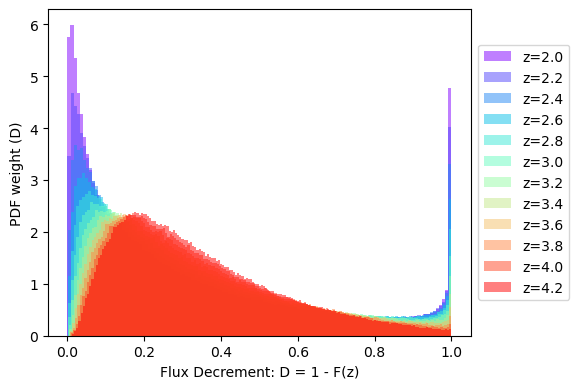

In [46]:
# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2])

norm = plt.Normalize(min(zlist), max(zlist))  # Normalize to the range of z_list

for i, z in enumerate(zlist):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    pdf(z=z, variance=variance_1d, gaussian_k_field=gaussian_random_field_k, input_kmodes=kmodes, z0=3, color=color)

# Adjust the legend location
plt.legend(loc='right', bbox_to_anchor=(1.25, 0.5))  # Move the legend outside the plot
plt.tight_layout()  # Adjust layout to fit everything

plt.rcParams["figure.figsize"] = (6,4)
plt.show()  # Display the plot after all iterations


### Aside: Gauss-Hermite Quadrature Integration

$$ \int_{-\infty}^{\infty} e^{-x^2}dx \approx \Sigma_{i=1}^n  w_i f(x_i) $$

where, 

$ n = $ number of sample points,

$x_i = $ roots of Hermite Polynomial

$w_i = $ associated weights

#### numpy.polynomial.hermite.hermgauss

Computes the sample points and weights for Gauss-Hermite quadrature. These sample points and weights will correctly integrate polynomials of degree $2 * deg -1$ or less over the interval [-inf, inf], with weight function $f(x) = exp(x^2)$

$$ \bar{F}(z) = \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{\infty} \exp{[-\frac{\delta^2}{2 \sigma^2} - x(z) e^{2 a(z)\delta}]d\delta} $$

where, 

$$ x(z) \equiv 0.55 (\frac{1+z}{1+z_0})^{5.1} e^{-a^2(z)\sigma^2} $$

To modify for Gauss-Hermite quadrature: 

$$ I = \int_{-\infty}^{\infty} e^{- \frac{\delta^2}{2 \sigma^2}} \times e^{-x(z)\times e^{2 a(z) \delta}} d\delta$$

$$ I = \int_{-\infty}^{\infty} \exp ( - \frac{\delta^2}{2 \sigma^2} - x(z) \times e^{2 a(z) \delta} )  d\delta $$

Simplify by substituting $\alpha = \frac{1}{2 \sigma^2}$ and $\beta = x(z)$. Then: 

$$ I = \int_{-\infty}^{\infty} \exp(-\alpha \delta^2 - \beta e^{2 a(z)\delta}) d\delta $$

In the Gauss-Hermite quadrature framework, we need the form of $\int_{-\infty}^{\infty} e^{-x^2}f(x)dx$, so we make the changes: 

$$ \delta = \sqrt{2 \sigma^2}x $$

and

$$ d\delta = \sqrt{2 \delta^2}dx $$

then, substituting:

$$ I = \int_{-\infty}^{\infty} \exp(-\frac{(\sqrt{2\sigma^2}x)^2}{2\sigma^2} - \beta e^{2 a(z) \sqrt{2\sigma^2}x})\times \sqrt{2 \sigma^2}x dx$$

$$ I = \sqrt{2 \sigma^2} \int_{-\infty}^{\infty} \exp(-x^2 - \beta e^{2 a(z) \sqrt{2\sigma^2}x}) dx $$

Then, we need to idenltify f(x) for the approximation: 

$$ f(x) = \exp(-\beta e^{2 a(z)\sqrt{2\sigma^2}x}) $$

And in the form of Gauss-Hermite quadrature, we can rewrite the integral: 

$$ \int_{-\infty}^{\infty} e^{x^2} f(x)dx \approx \Sigma_{i=1}^{N}w_i \times f(x_i) $$

becomes:

$$ I \approx \sqrt{2\sigma^2} \Sigma_{i=1}^{N}w_i \times \exp(- \beta e^{2 a(z) \sqrt{2\sigma^2}x_i}) $$

where $x_i$ and $w_i$ are the nodes and weights of for Gauss-Hermite quadrature.

In [513]:
# use the approximation form above, resubmitting the substitution 
# Beta, adding the prefactor, and using n=10

def gh_mean_flux(n, z, variance, z0=3, a=58.6, b=-2.82):
    # Parameters
    sigma = np.sqrt(variance_1d)
    a_z = a_z(z,z0,a,b)
    beta = x_z(z, variance, z0)

    # Number of Gauss-Hermite nodes
    N = n

    # Compute Gauss-Hermite nodes and weights
    nodes, weights = hermgauss(N)

    # Transform nodes for the given problem
    transformed_nodes = np.sqrt(2 * sigma**2) * nodes

    # Compute the function values
    function_values = np.exp(-beta * np.exp(2 * a_z * transformed_nodes))

    # Compute the integral approximation
    integral_approximation = np.sqrt(2 * sigma**2) * np.sum(weights * function_values)

    # multiply by prefactor
    gh_prefactor = 1 / np.sqrt(2 * np.pi * variance)
    integral_approximation = integral_approximation * gh_prefactor
    
    return(integral_approximation)

In [167]:
# Compare to mean flux function: 

print('GH approximation: ' + str(gh_mean_flux(n=10, z=2.8, variance=variance_1d)))
print('Analytic:         ' + str(mean_flux(z=2.8, variance=variance_1d)))
print("Difference:      " + str(np.absolute(gh_mean_flux(n=10, z=2.8, variance=variance_1d)) - mean_flux(z=2.8, variance=variance_1d)))

GH approximation: 0.6736318309321093
Analytic:         0.6737381316528798
Difference:      -0.00010630072077044694


/tmp/ipykernel_1564401/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


/tmp/ipykernel_1564401/1927137723.py:10: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((x_z(z, variance)) * np.exp(2 * (redshift_evolution(z)) * x)))


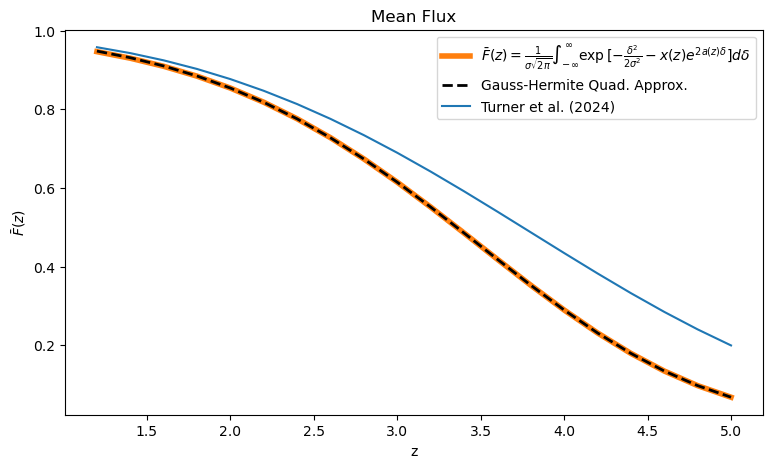

In [168]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ])

mean_flux_list = []
gh_flux_list = []
difference_list = []
for i in z_list:
    mean_flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))
    gh_flux_list.append(gh_mean_flux(n=10, z=i, variance=variance_1d, z0=3))
    difference_list.append(np.absolute(mean_flux(z=i,variance=variance_1d, z0=3) - gh_mean_flux(n=10, z=i, variance=variance_1d, z0=3)))
    
plt.plot(z_list, mean_flux_list, label = r'$\bar F(z) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^{\infty}\exp{[-\frac{\delta^2}{2 \sigma^2}-x(z)e^{2 a(z)\delta}]d\delta}$', linewidth=4, color = 'tab:orange')
plt.plot(z_list, gh_flux_list, label = 'Gauss-Hermite Quad. Approx.', ls = '--', linewidth=2, color='black')
plt.plot(z_list, np.exp(-2.46e-3*(1+z_list)**3.62), label='Turner et al. (2024)', color = 'tab:blue')


plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
# plt.vlines(x=2.8, ymin=0, ymax=1, ls='dotted', color = 'black',label='z = 2.8')
plt.legend()
plt.rcParams["figure.figsize"] = (7,4)


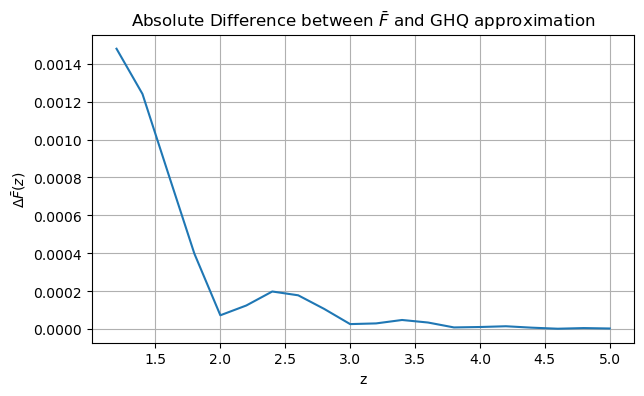

In [169]:
plt.plot(z_list, difference_list)
    
plt.title(r'Absolute Difference between $\bar{F}$ and GHQ approximation')
plt.xlabel('z')
plt.ylabel(r'$\Delta \bar F(z) $')
plt.grid(True)